# Part III. xbatcher

**Author:** Eli Holmes (NOAA)



## Shutdown kernels!

Kernel > Shutdown All Kernels

Make sure to reset things so we don't run out of memory.

## Load the libraries

In [1]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

import xbatcher

# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

2025-06-12 03:11:59.259629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 03:11:59.289011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 03:11:59.298046: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## See what machine we are on

In [2]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


## Load data

I created the data for Part I in `Data_Prep_Part_2`. Here I will load.

- sst, so, sin_time, cos_time
- ocean_mask
- y (CHL)

In [3]:
# read in the Zarr file; a 3D (time, lat, lon) cube for a bunch of variables in the Indian Ocean
dataset = xr.open_zarr("~/shared-readwrite/cnn/part2.zarr")
# Fix nan
# Replace NaNs with 0 for selected variables
vars_to_fill = ["sst", "so", "y"]
for var in vars_to_fill:
    dataset[var] = dataset[var].fillna(0)
dataset

<xarray.Dataset> Size: 173MB
Dimensions:     (time: 321, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    cos_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    ocean_mask  (lat, lon) float32 108kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    so          (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    sst         (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    y           (time, lat, lon) float32 35MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>

## Set up our train, validation and test datasets

User random selection of days.

In [4]:
import numpy as np

def split_dataset_random_time(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    """
    Randomly split dataset over the time dimension into train, val, and test sets.
    """
    time = dataset.time
    total = len(time)
    indices = np.arange(total)

    # Shuffle time indices
    np.random.seed(seed)
    np.random.shuffle(indices)

    # Split indices
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    train_idx = indices[:train_end]
    val_idx = indices[train_end:val_end]
    test_idx = indices[val_end:]

    # Index into dataset
    train_ds = dataset.isel(time=train_idx)
    val_ds = dataset.isel(time=val_idx)
    test_ds = dataset.isel(time=test_idx)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset_random_time(dataset)

## Set up xbatcher

In [5]:
from xbatcher import BatchGenerator

input_vars = ["sst", "so", "sin_time", "cos_time", "ocean_mask"]
output_vars = ["y"]
input_dims = {"time": 1, "lat": 64, "lon": 64}
input_overlap = {"time": 0, "lat": 0, "lon": 0}

# 1. Split the dataset
ds_sel = dataset[input_vars + output_vars]
train_ds, val_ds, test_ds = split_dataset_random_time(ds_sel)

# 2. Create batch generators
train_gen = BatchGenerator(train_ds, input_dims=input_dims, input_overlap=input_overlap)
val_gen = BatchGenerator(val_ds, input_dims=input_dims, input_overlap=input_overlap)
test_gen = BatchGenerator(test_ds, input_dims=input_dims, input_overlap=input_overlap)

In [6]:
# Helper to extract arrays for model
def train_gen_tf_batches():
    for batch in train_gen:
        x = np.stack([
            batch[var].isel(time=0).data if "time" in batch[var].dims else batch[var].data
            for var in input_vars
        ], axis=-1)  # shape: (lat, lon, n_features)        
        y = batch["y"].isel(time=0).data[..., np.newaxis]  # shape: (lat, lon, 1)
        yield x, y

def val_gen_tf_batches():
    for batch in val_gen:
        x = np.stack([
            batch[var].isel(time=0).data if "time" in batch[var].dims else batch[var].data
            for var in input_vars
        ], axis=-1)  # shape: (lat, lon, n_features)
        y = batch["y"].isel(time=0).data[..., np.newaxis]  # shape: (lat, lon, 1)
        yield x, y

# Wrap in tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    train_gen_tf_batches,
    output_signature=(
        tf.TensorSpec(shape=(64, 64, len(input_vars)), dtype=tf.float32),
        tf.TensorSpec(shape=(64, 64, 1), dtype=tf.float32),
    )
)

val_dataset = tf.data.Dataset.from_generator(
    val_gen_tf_batches,
    output_signature=(
        tf.TensorSpec(shape=(64, 64, len(input_vars)), dtype=tf.float32),
        tf.TensorSpec(shape=(64, 64, 1), dtype=tf.float32),
    )
)

BATCH_SIZE = 8
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:

# check that shape is (8, 64, 64, 5)
for x, y in train_dataset.take(1):
    print("Train x shape:", x.shape)
    print("Train y shape:", y.shape)

Train x shape: (8, 64, 64, 5)
Train y shape: (8, 64, 64, 1)


## Create the CNN model

In [7]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

### Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. The model has ~20,000 trainable parameters, which we can see from `model.summary()`. This is small compared to huge modern CNNs (millions of parameters).

In [8]:
input_shape = (64, 64, len(input_vars))
model = create_model_CNN(input_shape)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    validation_data=val_dataset, # Use validation data during training
    callbacks=[early_stop]       # Stop early if no improvement
)

Epoch 1/50
    104/Unknown 42s 311ms/step - loss: 0.9634 - mae: 0.9634

/srv/conda/envs/notebook/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


112/112 ━━━━━━━━━━━━━━━━━━━━ 52s 384ms/step - loss: 0.9463 - mae: 0.9463 - val_loss: 0.3854 - val_mae: 0.3854
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - loss: 0.5237 - mae: 0.5237 - val_loss: 0.4191 - val_mae: 0.4191
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 392ms/step - loss: 0.4721 - mae: 0.4721 - val_loss: 0.3700 - val_mae: 0.3700
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 390ms/step - loss: 0.4365 - mae: 0.4365 - val_loss: 0.4093 - val_mae: 0.4093
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 47s 386ms/step - loss: 0.4275 - mae: 0.4275 - val_loss: 0.3377 - val_mae: 0.3377
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 388ms/step - loss: 0.3985 - mae: 0.3985 - val_loss: 0.3584 - val_mae: 0.3584
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 391ms/step - loss: 0.3681 - mae: 0.3681 - val_loss: 0.2721 - val_mae: 0.2721
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 389ms/step - loss: 0.3844 - mae: 0.3844 - val_loss: 0.3462 - val_mae: 0.3462
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 48s

## Let's train the model

## Plot training & validation loss values

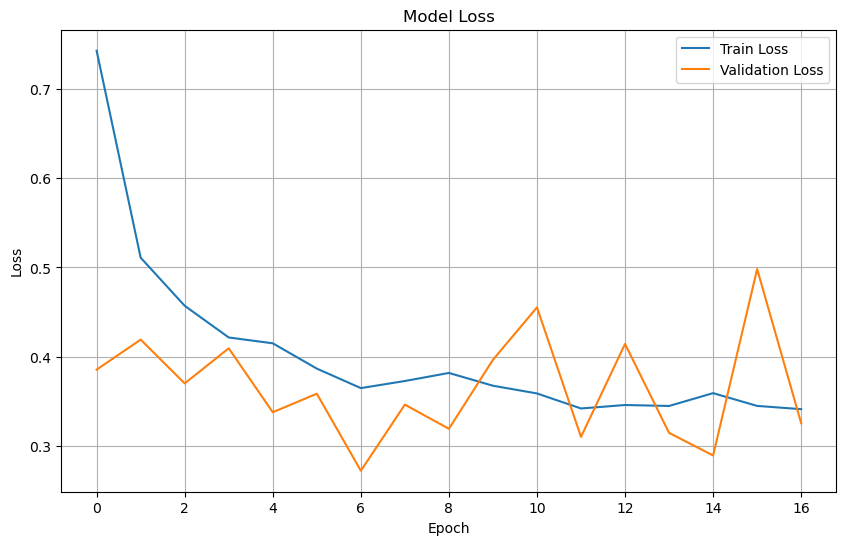

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [12]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

NameError: name 'X_test' is not defined

## Make some maps of our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


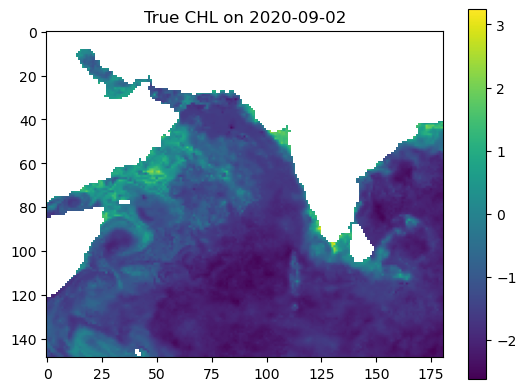

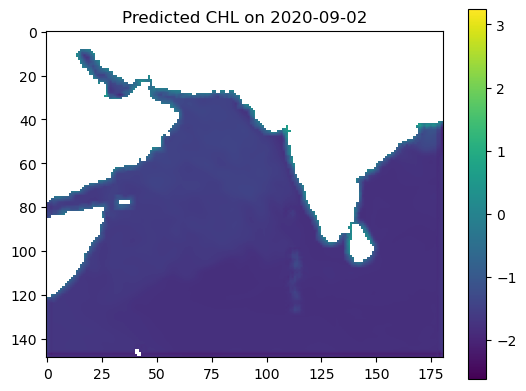

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Example: date to predict
date_to_predict = np.datetime64("2020-09-02")

# Extract dataset slice for this time
ds_at_time = dataset.sel(time=date_to_predict)

# Prepare input (shape = [lat, lon, n_features])
input_data = np.stack([
    ds_at_time[var].values for var in input_vars
], axis=-1)  # shape = (lat, lon, n_features)

# Add batch dimension
input_data = input_data[np.newaxis, ...]  # shape = (1, lat, lon, n_features)

# Predict
predicted_output = model.predict(input_data)[0, ..., 0]  # shape = (lat, lon)

# True value from y
true_output = ds_at_time["y"].values  # shape = (lat, lon)

# Mask land (land_mask = ~ocean)
land_mask = ~dataset["ocean_mask"].values.astype(bool)
predicted_output[land_mask] = np.nan
true_output[land_mask] = np.nan

# Plot
vmin = np.nanmin([true_output, predicted_output])
vmax = np.nanmax([true_output, predicted_output])

plt.imshow(true_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"True CHL on {date_to_predict}")
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"Predicted CHL on {date_to_predict}")
plt.show()



### Let's look at all the months

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


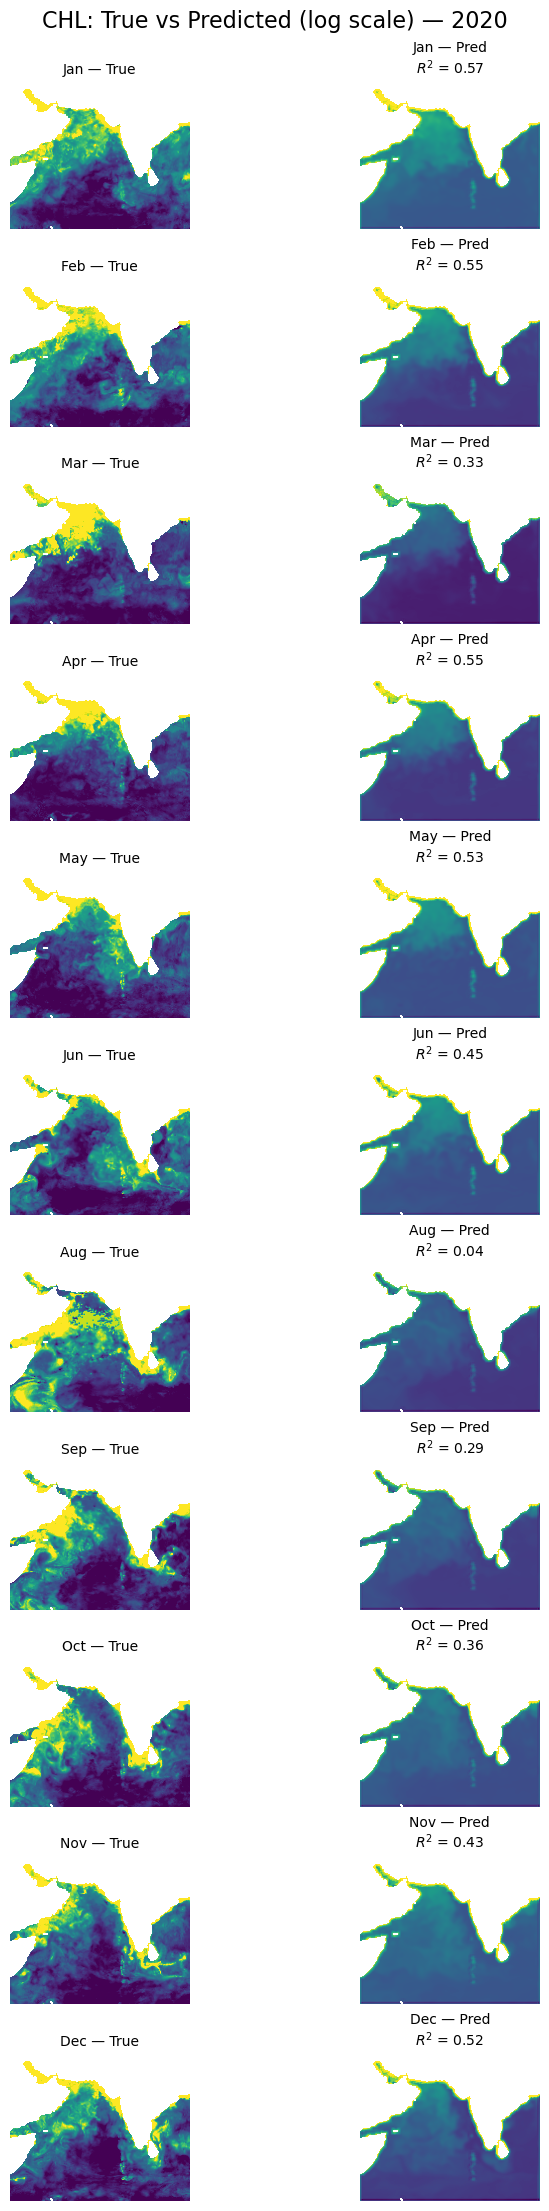

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Get available time points and group by month
available_dates = pd.to_datetime(dataset.time.values)
monthly_dates = (
    pd.Series(available_dates)
    .groupby([available_dates.year, available_dates.month])
    .min()
    .sort_values()
)
n_months = len(monthly_dates)

# lat/lon info
lat = dataset.lat.values
lon = dataset.lon.values
extent = [lon.min(), lon.max(), lat.min(), lat.max()]
flip_lat = lat[0] > lat[-1]
land_mask = ~dataset["ocean_mask"].values.astype(bool)

# Create figure and axes
fig, axs = plt.subplots(n_months, 2, figsize=(7, 2 * n_months), constrained_layout=True)

for i, date in enumerate(monthly_dates):
    # Select dataset for this date
    ds_at_time = dataset.sel(time=np.datetime64(date))

    # Prepare model input: stack input variables into (lat, lon, n_features)
    input_data = np.stack([
        ds_at_time[var].values for var in input_vars
    ], axis=-1)

    # Predict: shape (lat, lon)
    predicted_output = model.predict(input_data[np.newaxis, ...])[0, ..., 0]

    # True output
    true_output = ds_at_time["y"].values

    # Mask land
    predicted_output[land_mask] = np.nan
    true_output[land_mask] = np.nan

    # Flip latitude if needed
    if flip_lat:
        true_output = np.flipud(true_output)
        predicted_output = np.flipud(predicted_output)

    # Shared color scale
    vmin = np.nanpercentile([true_output, predicted_output], 5)
    vmax = np.nanpercentile([true_output, predicted_output], 95)

    # Compute R²
    true_flat = true_output.flatten()
    pred_flat = predicted_output.flatten()
    valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
    r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])

    # Plot true
    axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis',
                     aspect='equal')
    axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
    axs[i, 0].axis('off')

    # Plot predicted with R²
    axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                     vmin=vmin, vmax=vmax, cmap='viridis', 
                     aspect='equal')
    axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}", fontsize=10)
    axs[i, 1].axis('off')

plt.suptitle('CHL: True vs Predicted (log scale) — 2020', fontsize=16)
plt.show()


## Summary

Now we have a model that is doing ok. It still doesn't pick up the upwelling zone at the southern tip of India. There is something about that area that is different and that the model is unable to learn. We should look into what drives that upwelling zone. It maybe that the relationship between SST and salinity are different there. It pokes down into a strong E-W current system.